# Grad-CAM
visualize attention of the network

In [1]:
from grad_cam import *
import sys
sys.path.append("../")
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
# import torch.utils.data
import torch.utils.data as data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
import models
import utils.flops as flops

In [3]:
model = models.__dict__["resnext101"](num_classes=100,nodownsample = False)
model = torch.nn.DataParallel(model).cuda()
# checkpoint = torch.load("../resnext101_.checkpoint.pth.tar_bak")
checkpoint = torch.load("../trained_checkpoints/resnext101_nods.checkpoint.pth.tar")

model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})"
      .format("../resnext101_.checkpoint.pth.tar", checkpoint['epoch']))

=> loaded checkpoint '../resnext101_.checkpoint.pth.tar' (epoch 115)


In [4]:
def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (224,) * 2)
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

In [5]:
images = []
raw_images = []
print("Images:")
image_paths = ["cifar_bottle.png"]#,"cat_dog.png"]
for i, image_path in enumerate(image_paths):
    print("\t#{}: {}".format(i, image_path))
    image, raw_image = preprocess(image_path)
    images.append(image)
    raw_images.append(raw_image)
images = torch.stack(images).cuda()


bp = BackPropagation(model=model)
probs, ids = bp.forward(images)

gcam = GradCAM(model=model,candidate_layers=["module.layer4.2.conv3"])
_ = gcam.forward(images)

gbp = GuidedBackPropagation(model=model)
_ = gbp.forward(images)

Images:
	#0: cifar_bottle.png


In [6]:
for name, module in gbp.model.named_modules():
    print (name)


module
module.conv1
module.bn1
module.relu
module.maxpool
module.layer1
module.layer1.0
module.layer1.0.conv1
module.layer1.0.bn1
module.layer1.0.conv2
module.layer1.0.bn2
module.layer1.0.conv3
module.layer1.0.bn3
module.layer1.0.relu
module.layer1.0.downsample
module.layer1.0.downsample.0
module.layer1.0.downsample.1
module.layer1.1
module.layer1.1.conv1
module.layer1.1.bn1
module.layer1.1.conv2
module.layer1.1.bn2
module.layer1.1.conv3
module.layer1.1.bn3
module.layer1.1.relu
module.layer1.2
module.layer1.2.conv1
module.layer1.2.bn1
module.layer1.2.conv2
module.layer1.2.bn2
module.layer1.2.conv3
module.layer1.2.bn3
module.layer1.2.relu
module.layer2
module.layer2.0
module.layer2.0.conv1
module.layer2.0.bn1
module.layer2.0.conv2
module.layer2.0.bn2
module.layer2.0.conv3
module.layer2.0.bn3
module.layer2.0.relu
module.layer2.0.downsample
module.layer2.0.downsample.0
module.layer2.0.downsample.1
module.layer2.1
module.layer2.1.conv1
module.layer2.1.bn1
module.layer2.1.conv2
module.laye

In [12]:
gbp.backward(ids=ids[:, [1]])
gradients = gbp.generate()

# Grad-CAM
gcam.backward(ids=ids[:, [1]])
regions = gcam.generate(target_layer="module.layer4.2.conv3")

In [13]:
print(ids)

tensor([[87, 72, 40, 50, 44, 10, 89, 91, 32, 29, 37, 64, 18, 61, 66, 51, 26, 80,
         90, 35, 79,  3, 45, 57, 15, 36, 65, 98,  9, 93, 11,  1, 19, 42, 25, 34,
          6, 74, 97, 84, 46, 22, 86, 55,  8, 78, 28, 69, 13, 81, 14,  2,  7, 73,
          4, 31, 99, 27, 38, 85, 75, 88,  5, 12, 41, 56, 58, 67, 16, 33, 48, 63,
         21, 54, 77, 68, 43, 83, 20, 39, 49, 24, 82, 92, 23, 59, 71, 76, 30, 17,
         62, 70, 53, 96,  0, 95, 94, 60, 47, 52]], device='cuda:0')


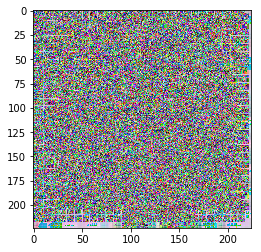

In [14]:
gradients = gradients[0].cpu().numpy().transpose(1, 2, 0)
gradients -= gradients.min()
gradients /= gradients.max()
gradients *= 255.0
plt.imshow(gradients)
plt.show()

In [15]:
print(regions.shape)

torch.Size([1, 1, 224, 224])


(224, 224, 1, 3)
(224, 224, 3)


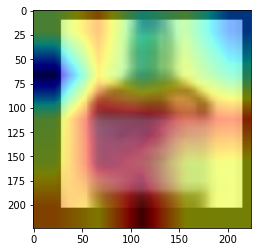

In [16]:
region = regions[0].cpu().numpy().transpose(1, 2, 0)
cmap = cm.jet_r(region)[..., :3] * 255.0
print(cmap.shape)
cmap = cmap.reshape(224,224,3)
region = (cmap.astype(np.float) + raw_images[0].astype(np.float)) / 2
# print(region.shape)
region = np.uint8(region)
# print(region)
# 
print(cmap.shape)
plt.imshow(region)
plt.imsave("pics\dump.png",region)
plt.show()

### gradCam初步分析
首先，cifar的图片竟然如此之模糊，如此之小！

原来的代码里面是强行把图片扩大之后做的实验，这也说明，我前面所有训练的网络都不能说明什么问题，因为cifar本身是32*32 的数据集，代码里面扩大成224*224。。。。。。。。


下图是nods识别分数最高的类，网络对grad_cam的响应，识别的结果是32 flatfish，但是貌似正确答案是9 bottle
![](pics\cifar_bottle_nodsGcam.png)
![](pics\cifar_bottle_nodsGcam_1.png)

下图是有ds 识别分数最高的类，网络对grad_cam的响应，识别的结果是10 bowl，但是貌似正确答案是9 bottle
![](pics\cifar_bottle_Gcam_1.png)
![](pics\cifar_bottle_Gcam_2.png)
![](pics\cifar_bottle_Gcam_3.png)
![](pics\cifar_bottle_Gcam_4.png)

我只能说，这个对我而言好像还是一个**不成熟的技术**, 我重新跑这个的结果都不一样（加载同样的网络）


In [25]:
import pickle as pkl

In [26]:
with open("C:/Users/11657/dataset/vgg100/cifar-100-python/meta","rb") as f:
     meta = pkl.load(f)


In [27]:
print(meta)

{'fine_label_names': ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'w

In [83]:
len(meta['fine_label_names'])

100

In [28]:
for i, name in enumerate(meta["fine_label_names"]):
    print(i,name)

0 apple
1 aquarium_fish
2 baby
3 bear
4 beaver
5 bed
6 bee
7 beetle
8 bicycle
9 bottle
10 bowl
11 boy
12 bridge
13 bus
14 butterfly
15 camel
16 can
17 castle
18 caterpillar
19 cattle
20 chair
21 chimpanzee
22 clock
23 cloud
24 cockroach
25 couch
26 crab
27 crocodile
28 cup
29 dinosaur
30 dolphin
31 elephant
32 flatfish
33 forest
34 fox
35 girl
36 hamster
37 house
38 kangaroo
39 keyboard
40 lamp
41 lawn_mower
42 leopard
43 lion
44 lizard
45 lobster
46 man
47 maple_tree
48 motorcycle
49 mountain
50 mouse
51 mushroom
52 oak_tree
53 orange
54 orchid
55 otter
56 palm_tree
57 pear
58 pickup_truck
59 pine_tree
60 plain
61 plate
62 poppy
63 porcupine
64 possum
65 rabbit
66 raccoon
67 ray
68 road
69 rocket
70 rose
71 sea
72 seal
73 shark
74 shrew
75 skunk
76 skyscraper
77 snail
78 snake
79 spider
80 squirrel
81 streetcar
82 sunflower
83 sweet_pepper
84 table
85 tank
86 telephone
87 television
88 tiger
89 tractor
90 train
91 trout
92 tulip
93 turtle
94 wardrobe
95 whale
96 willow_tree
97 wolf
98

In [52]:
import torch.utils.data as data
import torchvision.transforms as transform
import matplotlib.pyplot as plt

normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
resize = transforms.RandomResizedCrop(224)
traindata_transforms = transforms.Compose([
            resize,
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])#,
#             normalize])
dataloader = data.DataLoader(
                dataset=datasets.CIFAR100(root="~/dataset/vgg100", train=True, download=False, transform=traindata_transforms),
                batch_size=32,
                shuffle=True,
                num_workers=4,
                pin_memory=True)

In [53]:
tmpi = None
tmpl = None
for img,label in dataloader:
    tmpi = img
    tmpl = label
    print(img.shape)
    print(label)
    
    break

torch.Size([32, 3, 224, 224])
tensor([ 9, 44, 19, 97, 28, 85, 23, 66, 79, 29, 17, 85, 45, 31, 70, 36, 87, 54,
        32, 18, 13, 63, 57, 34, 69, 88, 77, 61, 28, 82, 15, 39])


(224, 224, 3)


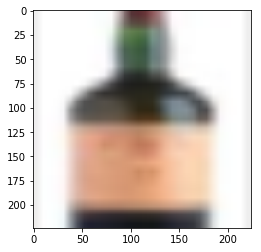

In [54]:
a = tmpi[0]
a = np.transpose(a,(1,2,0))
a = np.uint8(a/a.max()*255)
print(a.shape)
plt.imshow(a)
plt.show()